<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-WDaugherty/blob/main/3_training_and_analysis_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Training and Testing**
Please start early! Section 3.6 Training may take one to two hours to run. 

## 3.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [4]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-WDaugherty' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-WDaugherty
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 343 bytes | 4.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a2-WDaugherty
   38a3bc2..d7907bd  main       -> origin/main
Updating 38a3bc2..d7907bd
Fast-forward
 src/bonus_constants.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
/content/gdrive/MyDrive/ece5545


In [5]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU

Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save



### Import code dependencies

In [6]:
import os
import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

# Import constants to use constants defined for training
from src.bonus_constants import *
# Import data_proc to use data processing functions
import src.data_proc as data_proc

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.
Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 3.1 Download and Preprocess Data

### Create audio processor
This step is similar to what was done in part 2, so the files should already be downloaded in your Google Drive.

In [7]:
# Create audio_processor
audio_processor = data_proc.AudioProcessor()

### Select device: cuda or cpu

In [8]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

Using cpu to run the training scrpit.


## 3.2 Data Loader

In [9]:
# Define train, test, and validation set
train_set = audio_processor.data_index['training']
test_set = audio_processor.data_index['testing']
valid_set = audio_processor.data_index['validation']

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

Train size: 10556 Val size: 1333 Test size: 1368


## 3.3 Define the Model

In [10]:
from src.networks import TinyConv
# Create a full precision (float32) TinyConv model
model_fp32 = TinyConv(
    model_settings=audio_processor.model_settings,
    n_input=1,
    n_output=audio_processor.num_labels
)
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

## 3.4 Training

In [11]:
from src.train_val_test_utils import train, test

### Adjust parameters
*   You can change *n_epoch* to use a different number training steps/epochs

In [12]:
num_batches = len(train_loader)
n_epoch = 50
print(f'# batches: {num_batches} \n# epochs: {n_epoch} \n# total training steps: {num_batches * n_epoch}')

# batches: 106 
# epochs: 50 
# total training steps: 5300


### Create optimizer for training
 Explore more at: 
[TORCH. OPTIM](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20lr_scheduler)

In [13]:
from src.train_val_test_utils import create_optimizer

# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_fp32.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'params': [0, 1, 2, 3]}]}


### Train the model
TensorBoard will allow you to visualize your results. The second code block, the training, will take a while to run.

In [14]:
bar_update = 1 / (len(train_loader) + len(test_loader) + len(valid_loader))

def run_training(model, data_loaders, n_epoch, optimizer,
                 save_interval=1, resume=True, checkpoint_path=None):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
      
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        last_valacc = 0
        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            
            train(model, data_loaders, optimizer, 
                      epoch, device)
            
            valacc = test(valid_loader, model, device, epoch=epoch, 
                          loader_type='Valid', verbose=True)
            #checkpoint the model every epoch
            if epoch % save_interval == 0 and valacc > last_valacc:
                last_valacc = valacc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, checkpoint_path)
                
            # Update epoch pbar
            pbar.update(1)
        
        testacc = test(test_loader, model, device, 
                     epoch=None, loader_type='Test')
        print(f'Test Acc = {round(testacc,2)}%')


# This is where your checkpoint file will be saved
checkpoint_path = os.path.join(TORCH_DIR, "fp32_checkpoint.pt")

model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders, 
    n_epoch=n_epoch, optimizer=optimizer_fp32, 
    resume=True, checkpoint_path=checkpoint_path
)

  0%|          | 0/50 [00:00<?, ?it/s]

Val Acc Epoch 1 = 82.0%, Train loss = 1.106

Valid epoch: 1	Accuracy: 1101/1333 (82.60%)

Val Acc Epoch 2 = 84.62%, Train loss = 0.552

Valid epoch: 2	Accuracy: 1133/1333 (85.00%)

Val Acc Epoch 3 = 87.17%, Train loss = 0.483

Valid epoch: 3	Accuracy: 1169/1333 (87.70%)

Val Acc Epoch 4 = 86.42%, Train loss = 0.455

Valid epoch: 4	Accuracy: 1150/1333 (86.27%)

Val Acc Epoch 5 = 88.45%, Train loss = 0.445

Valid epoch: 5	Accuracy: 1166/1333 (87.47%)

Val Acc Epoch 6 = 88.45%, Train loss = 0.439

Valid epoch: 6	Accuracy: 1176/1333 (88.22%)

Val Acc Epoch 7 = 88.0%, Train loss = 0.422

Valid epoch: 7	Accuracy: 1183/1333 (88.75%)

Val Acc Epoch 8 = 87.85%, Train loss = 0.415

Valid epoch: 8	Accuracy: 1178/1333 (88.37%)

Val Acc Epoch 9 = 88.52%, Train loss = 0.391

Valid epoch: 9	Accuracy: 1182/1333 (88.67%)

Val Acc Epoch 10 = 88.3%, Train loss = 0.411

Valid epoch: 10	Accuracy: 1185/1333 (88.90%)

Val Acc Epoch 11 = 88.9%, Train loss = 0.41

Valid epoch: 11	Accuracy: 1179/1333 (88.45%)



In [15]:
STRING = '''
Val Acc Epoch 1 = 82.0%, Train loss = 1.106

Valid epoch: 1	Accuracy: 1101/1333 (82.60%)

Val Acc Epoch 2 = 84.62%, Train loss = 0.552

Valid epoch: 2	Accuracy: 1133/1333 (85.00%)

Val Acc Epoch 3 = 87.17%, Train loss = 0.483

Valid epoch: 3	Accuracy: 1169/1333 (87.70%)

Val Acc Epoch 4 = 86.42%, Train loss = 0.455

Valid epoch: 4	Accuracy: 1150/1333 (86.27%)

Val Acc Epoch 5 = 88.45%, Train loss = 0.445

Valid epoch: 5	Accuracy: 1166/1333 (87.47%)

Val Acc Epoch 6 = 88.45%, Train loss = 0.439

Valid epoch: 6	Accuracy: 1176/1333 (88.22%)

Val Acc Epoch 7 = 88.0%, Train loss = 0.422

Valid epoch: 7	Accuracy: 1183/1333 (88.75%)

Val Acc Epoch 8 = 87.85%, Train loss = 0.415

Valid epoch: 8	Accuracy: 1178/1333 (88.37%)

Val Acc Epoch 9 = 88.52%, Train loss = 0.391

Valid epoch: 9	Accuracy: 1182/1333 (88.67%)

Val Acc Epoch 10 = 88.3%, Train loss = 0.411

Valid epoch: 10	Accuracy: 1185/1333 (88.90%)

Val Acc Epoch 11 = 88.9%, Train loss = 0.41

Valid epoch: 11	Accuracy: 1179/1333 (88.45%)

Val Acc Epoch 12 = 88.45%, Train loss = 0.397

Valid epoch: 12	Accuracy: 1181/1333 (88.60%)

Val Acc Epoch 13 = 88.3%, Train loss = 0.392

Valid epoch: 13	Accuracy: 1161/1333 (87.10%)

Val Acc Epoch 14 = 88.75%, Train loss = 0.387

Valid epoch: 14	Accuracy: 1184/1333 (88.82%)

Val Acc Epoch 15 = 88.97%, Train loss = 0.38

Valid epoch: 15	Accuracy: 1193/1333 (89.50%)

Val Acc Epoch 16 = 88.82%, Train loss = 0.383

Valid epoch: 16	Accuracy: 1174/1333 (88.07%)

Val Acc Epoch 17 = 89.05%, Train loss = 0.374

Valid epoch: 17	Accuracy: 1191/1333 (89.35%)

Val Acc Epoch 18 = 88.45%, Train loss = 0.392

Valid epoch: 18	Accuracy: 1183/1333 (88.75%)

Val Acc Epoch 19 = 89.5%, Train loss = 0.377

Valid epoch: 19	Accuracy: 1193/1333 (89.50%)

Val Acc Epoch 20 = 89.72%, Train loss = 0.36

Valid epoch: 20	Accuracy: 1188/1333 (89.12%)

Val Acc Epoch 21 = 89.35%, Train loss = 0.364

Valid epoch: 21	Accuracy: 1189/1333 (89.20%)

Val Acc Epoch 22 = 88.3%, Train loss = 0.361

Valid epoch: 22	Accuracy: 1190/1333 (89.27%)

Val Acc Epoch 23 = 88.97%, Train loss = 0.358

Valid epoch: 23	Accuracy: 1196/1333 (89.72%)

Val Acc Epoch 24 = 89.42%, Train loss = 0.361

Valid epoch: 24	Accuracy: 1197/1333 (89.80%)

Val Acc Epoch 25 = 88.6%, Train loss = 0.368

Valid epoch: 25	Accuracy: 1177/1333 (88.30%)

Val Acc Epoch 26 = 89.65%, Train loss = 0.364

Valid epoch: 26	Accuracy: 1200/1333 (90.02%)

Val Acc Epoch 27 = 89.42%, Train loss = 0.362

Valid epoch: 27	Accuracy: 1187/1333 (89.05%)

Val Acc Epoch 28 = 90.62%, Train loss = 0.355

Valid epoch: 28	Accuracy: 1188/1333 (89.12%)

Val Acc Epoch 29 = 90.32%, Train loss = 0.362

Valid epoch: 29	Accuracy: 1191/1333 (89.35%)

Val Acc Epoch 30 = 88.82%, Train loss = 0.359

Valid epoch: 30	Accuracy: 1187/1333 (89.05%)

Val Acc Epoch 31 = 90.25%, Train loss = 0.36

Valid epoch: 31	Accuracy: 1182/1333 (88.67%)

Val Acc Epoch 32 = 88.6%, Train loss = 0.364

Valid epoch: 32	Accuracy: 1174/1333 (88.07%)

Val Acc Epoch 33 = 88.82%, Train loss = 0.35

Valid epoch: 33	Accuracy: 1190/1333 (89.27%)

Val Acc Epoch 34 = 88.45%, Train loss = 0.354

Valid epoch: 34	Accuracy: 1190/1333 (89.27%)

Val Acc Epoch 35 = 89.87%, Train loss = 0.354

Valid epoch: 35	Accuracy: 1191/1333 (89.35%)

Val Acc Epoch 36 = 90.25%, Train loss = 0.351

Valid epoch: 36	Accuracy: 1190/1333 (89.27%)

Val Acc Epoch 37 = 89.57%, Train loss = 0.358

Valid epoch: 37	Accuracy: 1197/1333 (89.80%)

Val Acc Epoch 38 = 89.72%, Train loss = 0.354

Valid epoch: 38	Accuracy: 1191/1333 (89.35%)

Val Acc Epoch 39 = 90.62%, Train loss = 0.344

Valid epoch: 39	Accuracy: 1199/1333 (89.95%)

Val Acc Epoch 40 = 89.2%, Train loss = 0.353

Valid epoch: 40	Accuracy: 1198/1333 (89.87%)

Val Acc Epoch 41 = 90.4%, Train loss = 0.346

Valid epoch: 41	Accuracy: 1208/1333 (90.62%)

Val Acc Epoch 42 = 90.4%, Train loss = 0.333

Valid epoch: 42	Accuracy: 1204/1333 (90.32%)

Val Acc Epoch 43 = 90.32%, Train loss = 0.338

Valid epoch: 43	Accuracy: 1210/1333 (90.77%)

Val Acc Epoch 44 = 89.87%, Train loss = 0.345

Valid epoch: 44	Accuracy: 1195/1333 (89.65%)

Val Acc Epoch 45 = 88.9%, Train loss = 0.352

Valid epoch: 45	Accuracy: 1199/1333 (89.95%)

Val Acc Epoch 46 = 89.8%, Train loss = 0.353

Valid epoch: 46	Accuracy: 1212/1333 (90.92%)

Val Acc Epoch 47 = 90.1%, Train loss = 0.351

Valid epoch: 47	Accuracy: 1206/1333 (90.47%)

Val Acc Epoch 48 = 89.35%, Train loss = 0.345

Valid epoch: 48	Accuracy: 1204/1333 (90.32%)

Val Acc Epoch 49 = 90.77%, Train loss = 0.341

Valid epoch: 49	Accuracy: 1209/1333 (90.70%)

Val Acc Epoch 50 = 90.1%, Train loss = 0.348

Valid epoch: 50	Accuracy: 1203/1333 (90.25%)
'''

In [16]:

import re
import numpy as np
import matplotlib.pyplot as plt

def get_accs_and_plot(string):
    val_accs = []
    train_accs = []
    for i, line in enumerate(string.split('\n')):
        if 'Valid epoch' in line:
            val_acc = float(line.split('(')[-1].replace('%)','')) / 100.0
            val_accs.append(val_acc)
        elif 'Val Acc' in line:
            train_acc = float(re.findall(r'\d+\.\d+(?=%)', line)[0]) / 100.0
            train_accs.append(train_acc)
    epochs = range(1, len(val_accs) + 1)
    plt.plot(epochs, train_accs, '-', label='Train')
    plt.plot(epochs, val_accs, '-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return val_accs, train_accs

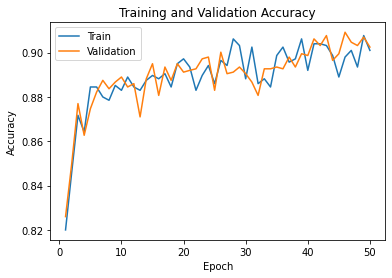

In [17]:

val_accs, train_accs = get_accs_and_plot(STRING)

## 3.5 Testing

### Calculating accuracy


Train size: 10556 Val size: 1333 Test size: 1368


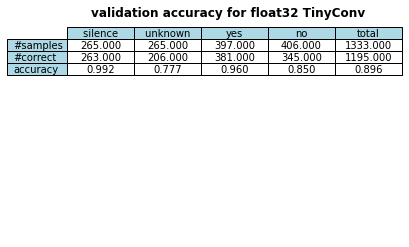

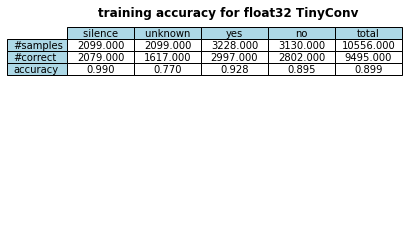

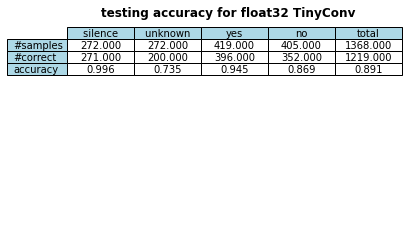

In [18]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "validation", 'float32 TinyConv', "float")
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "training", 'float32 TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'testing', 'float32 TinyConv', "float")

## 3.6 Save the Trained Model

In [19]:
def choose_name(model_name):
    name = f"{model_name}_" + "{index}"+ "_bonus"
    i = 0
    while os.path.isfile(name.format(index=i)):
        i += 1
    name = name.format(index = i)
    print(f"The model's will be stored as: \n {name}")
    return name

def save_model(model, path):
    torch.save(model.state_dict(), path)

In [20]:
# Choose a path
# You can also define your own path
model_name = f"tinyconv_float32_init_seed{torch.initial_seed()}_{acc * 100:.2f}%"
file_name = choose_name(model_name)
torch_path = os.path.join(TORCH_DIR, f'{file_name}.pt')
torch_path

The model's will be stored as: 
 tinyconv_float32_init_seed0_89.11%_0_bonus


'/content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_89.11%_0_bonus.pt'

In [21]:
# Save the trained pytorch model to torch_path
save_model(model_fp32, torch_path)
'Saved!'

'Saved!'

In [22]:
'You can now find your model in %s under the folder icon to the left.' % torch_path

'You can now find your model in /content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_89.11%_0_bonus.pt under the folder icon to the left.'